In [313]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import math 
import idx2numpy
import pandas as pd
%matplotlib inline

In [314]:
# load the data 
train_x = idx2numpy.convert_from_file('./data/train-images-idx3-ubyte')
train_y = idx2numpy.convert_from_file('./data/train-labels-idx1-ubyte')
test_x = idx2numpy.convert_from_file('./data/t10k-images-idx3-ubyte')
test_y = idx2numpy.convert_from_file('./data/t10k-labels-idx1-ubyte')

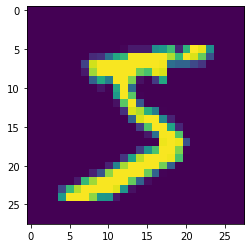

In [315]:
plt.imshow(train_x[0,:])
plt.show()

In [371]:
def createmvn(kernel_matrix): 
    mu, cov = np.zeros(tf.shape(kernel).numpy()[0]), kernel #tf.linalg.inv(kernel)

In [437]:
# Section 1 Question 2
# Sampling from a centered kernel. 

def create_kernel_matrix(kernelfunc, data):  
    return myarray(data.shape[0], lambda i, j: kernelfunc(data[int(i)] , data[int(j)])) 



def sampleRKHS(kernelfunc, data, ssize=12, center=True, rkhs_range=(-4,4), func_precision=100, diag_add=1e-6):
    """
    kernelfunc - lambda func that defines the kernel matrix of size dsize x dsize
    dsize - number of elements in the original dataset. 
    ssize - sample size, how many functions from RKHS to sample
    rkhs_range - what range to display the RKHS functions on
    func_precision - how many points to genereate in the rkhs_range (to draw lines) i.e resolution of lines

    returns X, Y -> X: domain values with shape(func_precision, ssize) Y: y values sampled RKHS functions 
    shape(func_precision, ssize) each col represents x and y values of each sampled function. 
    """
    K = create_kernel_matrix(kernelfunc, data) 
    if center:  
        IU = np.identity(data.shape[0]) - np.full((data.shape[0], data.shape[0]), 1 / data.shape[0])
        K = np.matmul(IU, np.matmul(K, IU))
    K += np.identity(data.shape[0]) * diag_add


    mvn = create_normal_distribution(K) 
    xi = np.linspace(rkhs_range[0], rkhs_range[1], func_precision) # this will be the domain we will be looking at of the RKHS space. 

    # create a matrix that will store the domains of the sampled value (linespace).
    # each column will be the same since we are analyzing them in the same domain.  
    y = np.reshape(xi.T, (xi.shape[0], 1)) # create a transpose of x (since each col will represent the points we are eval at)
    X_f = y
    X_k = y
    for i in range (0, ssize - 1): # range == # of datums in original dataset. 
        X_f = np.concatenate((X_f, y), axis=1)
    
    for i in range(0, data.shape[0] - 1): 
        X_k = np.concatenate((X_k, y), axis=1)

    
    # create functions evaluated at the 10 different basis functions 
    # each basis function is a kernel evaluated at each point holding second variable constant. 
    # in this case we are evaluating the second variable at (almost) all possible points (large number of rows representing domain)
    Kx = np.zeros((X_k.shape[0], data.shape[0]))


    for i in range(Kx.shape[0]): 
        for j in range(Kx.shape[1]):
            Kx[i, j] = kernelfunc(data[j], X_k[i, j])
    
    

    # now create the weighted functions now representing the actual functions in RKHS. 
    alphas = mvn.sample([ssize]).numpy() # sample the alpha weights by which each kernel function will be weighed. 
    # each fx will need its own alpha. Amount sampled is the amount of sample functions we want to generate. 
    Fx = np.matmul(Kx, alphas.T)
    return X_f, Fx, alphas,K


In [450]:
def create_normal_distribution(kernel): 
    # mu, cov = np.zeros(tf.shape(kernel).numpy()[0]), tf.linalg.inv(kernel)
    # scale = np.linalg.cholesky(cov)
    mu, cov = np.zeros(tf.shape(kernel).numpy()[0]), kernel
    scale = np.linalg.cholesky(cov)
    return tfp.distributions.MultivariateNormalTriL(loc=mu,scale_tril=scale)

(101, 101)
(12, 101)


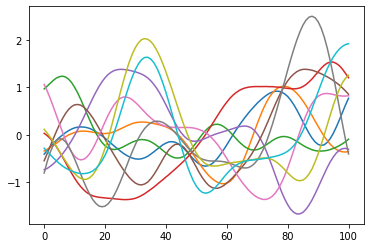

In [458]:
t=10
gk = lambda i, j: np.exp( (-1.0 /  ( 2.0 * t**2 )) * (i - j)**2 )
data = np.array([i for i in range(-100, 1)])
x,y,a,k = sampleRKHS(gk, data, rkhs_range=(-10,0))
print(k.shape)
print(a.shape)
# plt.title(r'$\tau = 0.5$')
# for i in range(0, 10): 
#     plt.plot(a[:, i])
for i in range(0, 10): 
    plt.plot(a[i, :])

#plt.savefig("./latex/figures/t05.pdf")

In [398]:
pd.DataFrame(a)

,0,1,2,3,4,5,6,7,8,9,10
0,-0.263635,-0.066223,-0.226859,1.130708,0.308703,-0.010065,0.571248,-0.435133,-0.443012,-1.097073,0.528693
1,0.166659,-0.418486,-1.487796,-0.318469,0.116675,0.459318,-1.385446,1.775522,0.640876,0.513990,-0.064084
2,0.515914,0.935977,-1.923149,-0.082888,1.035576,-0.705127,-1.449572,-0.395487,1.947024,0.446353,-0.321235
3,-1.896788,0.857891,-0.669993,-0.798054,0.310280,-0.365906,-0.203181,-0.230427,0.778683,0.778730,1.442387
4,0.456059,-1.567932,-0.104289,1.379628,0.662574,-0.774583,0.880873,-0.593843,-0.013831,-0.868030,0.540647
5,0.266418,0.678440,-0.248870,1.758430,-1.436416,0.331804,-2.023327,1.272491,0.156378,0.439789,-1.191245
6,0.042514,-0.284117,-0.460886,0.058747,-1.612747,-1.434964,-0.895538,0.869653,1.622335,1.196925,0.898038
7,-1.383013,-0.499761,-0.425419,-1.067767,0.663349,-0.601475,1.278360,0.204283,1.330723,1.102287,-0.600867
8,0.180684,-0.650800,0.038437,0.018758,0.588283,-2.756443,0.823655,0.914108,-0.115476,-0.536364,1.490178
9,-1.807921,0.313346,0.246247,-1.595135,-0.546291,1.907421,1.502697,0.692393,0.073046,0.249024,-1.033124


In [402]:
pd.DataFrame(k)

,0,1,2,3,4,5,6,7,8,9,10
0,0.906844,0.029875,-0.105155,-0.105491,-0.105491,-0.105491,-0.105491,-0.105491,-0.105491,-0.105460,-0.093157
1,0.029875,0.882237,0.017541,-0.117459,-0.117794,-0.117794,-0.117794,-0.117794,-0.117794,-0.117764,-0.105460
2,-0.105155,0.017541,0.882176,0.017511,-0.117489,-0.117825,-0.117825,-0.117825,-0.117825,-0.117794,-0.105491
3,-0.105491,-0.117459,0.017511,0.882176,0.017511,-0.117489,-0.117825,-0.117825,-0.117825,-0.117794,-0.105491
4,-0.105491,-0.117794,-0.117489,0.017511,0.882176,0.017511,-0.117489,-0.117825,-0.117825,-0.117794,-0.105491
5,-0.105491,-0.117794,-0.117825,-0.117489,0.017511,0.882176,0.017511,-0.117489,-0.117825,-0.117794,-0.105491
6,-0.105491,-0.117794,-0.117825,-0.117825,-0.117489,0.017511,0.882176,0.017511,-0.117489,-0.117794,-0.105491
7,-0.105491,-0.117794,-0.117825,-0.117825,-0.117825,-0.117489,0.017511,0.882176,0.017511,-0.117459,-0.105491
8,-0.105491,-0.117794,-0.117825,-0.117825,-0.117825,-0.117825,-0.117489,0.017511,0.882176,0.017541,-0.105155
9,-0.105460,-0.117764,-0.117794,-0.117794,-0.117794,-0.117794,-0.117794,-0.117459,0.017541,0.882237,0.029875


In [405]:
# check to see that the kernel functions average is 0
pd.DataFrame(np.matmul(k, np.full(k.shape, 1)))

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06
1,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06
2,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06
3,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06
4,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06
5,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06
6,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06
7,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06
8,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06
9,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06


In [406]:
# check to see that the sampled functions are approximately arround 0 + - 
pd.DataFrame(np.matmul(k, a.T))

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.461399,-0.519995,-0.927405,1.069331,-0.237642,-0.606795,0.723731,0.760081,-0.546385,0.447905,-1.736733,-0.467825
1,0.613240,-0.389115,0.845870,1.159064,1.552957,-1.210266,-2.102709,-1.672218,0.447279,-0.987315,-1.519350,-0.024750
2,0.726745,-0.209479,0.027650,-0.900850,0.723156,1.113075,-1.551353,-1.056212,1.171444,-3.434691,0.817793,-2.464197
3,-0.076817,0.003862,-0.309070,-0.108005,-0.049450,0.319605,-0.450841,0.895680,0.226948,-1.886447,1.045090,-1.620843
4,-0.243028,0.571116,0.118708,0.716520,-0.279779,1.875998,0.619450,0.090408,-0.269774,-0.722815,1.252520,-0.321146
5,0.119072,0.818961,-0.418777,-0.948419,0.769046,1.247825,-1.227731,0.623299,-0.640958,0.935436,1.228026,0.551783
6,-0.242626,-0.374280,0.830099,-1.233777,0.916836,-0.649103,0.205139,0.710905,-1.391902,0.050183,1.165487,0.558636
7,0.183831,0.983629,0.455193,-0.793816,-0.563919,-0.090874,1.386654,0.897375,-0.399413,2.296491,0.794134,1.771552
8,-1.127544,0.335428,-0.443546,0.796189,-2.497023,-1.247757,1.908485,-0.026419,-0.485108,1.628276,0.338466,1.036245
9,0.848635,-1.213181,-0.095121,0.703315,-0.386431,-0.273893,0.040342,-1.031099,1.996716,1.099695,-1.619884,0.641476


In [409]:
(np.matmul(k, a.T).min(), np.matmul(k, a.T).max())

(-3.4346910645572395, 2.2964906301072494)

In [410]:
np.matmul(k, a.T).mean()

2.4355197993055766e-12